cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from functions_cae import DeepCAE, train_cae, validate_cae, train_autoencoder, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, MLP, dropout_MLP
import matplotlib.pyplot as plt

In [2]:
##### CONFIG
NUM_EPOCHS = 5
LR_RATE = 1e-3
BATCH_SIZE = 4
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

# val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
#             '15_bottleNailPolisher']

# test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [3]:
train_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

Epoch [1/5], Loss: 0.6207, PSNR: 25.3331, SSIM: 0.8050


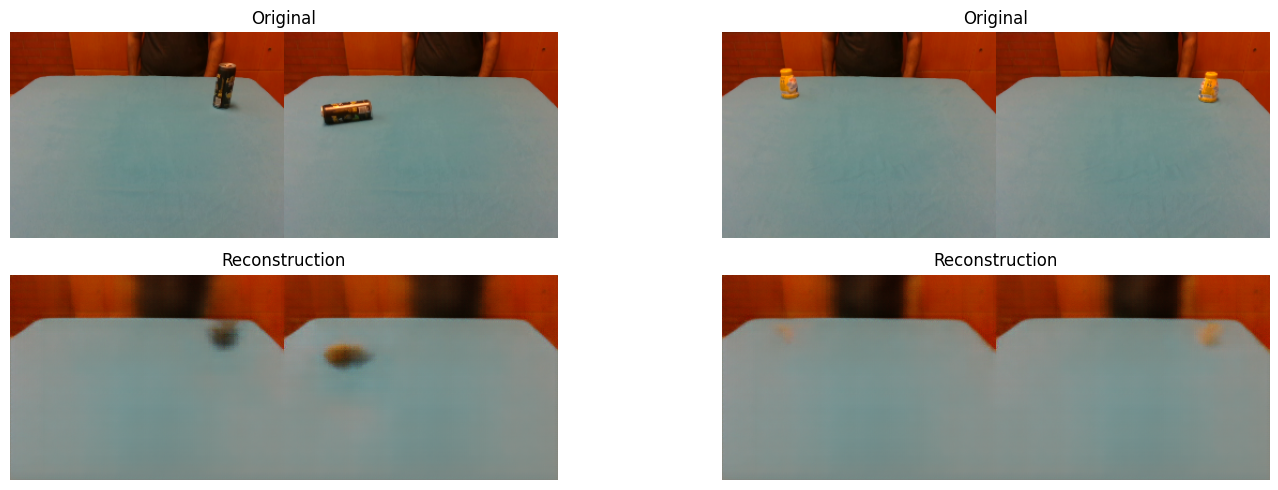

Epoch [2/5], Loss: 0.6112, PSNR: 30.0490, SSIM: 0.9399


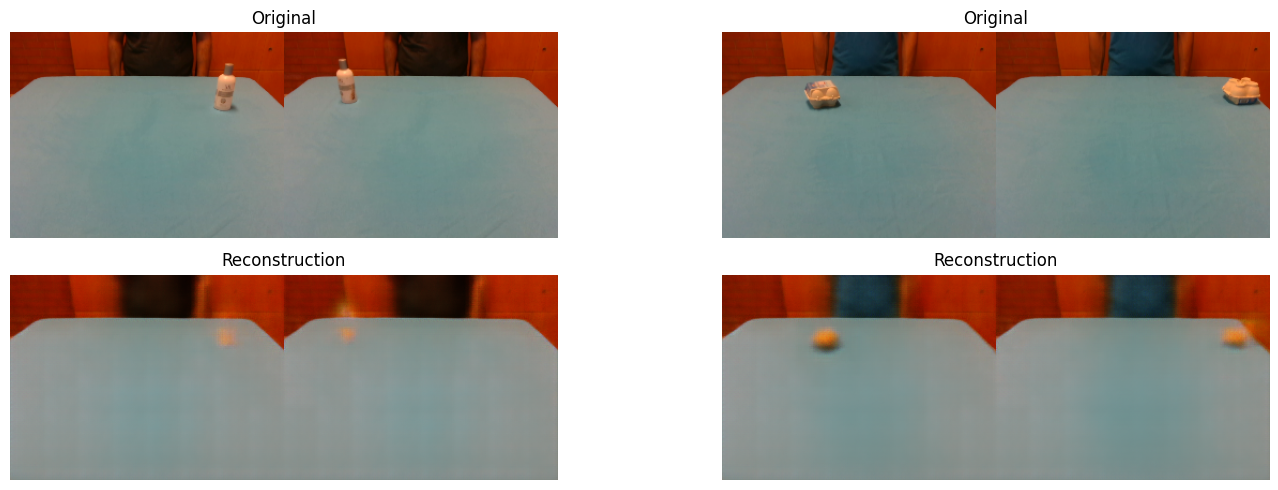

Epoch [3/5], Loss: 0.6105, PSNR: 31.2742, SSIM: 0.9556


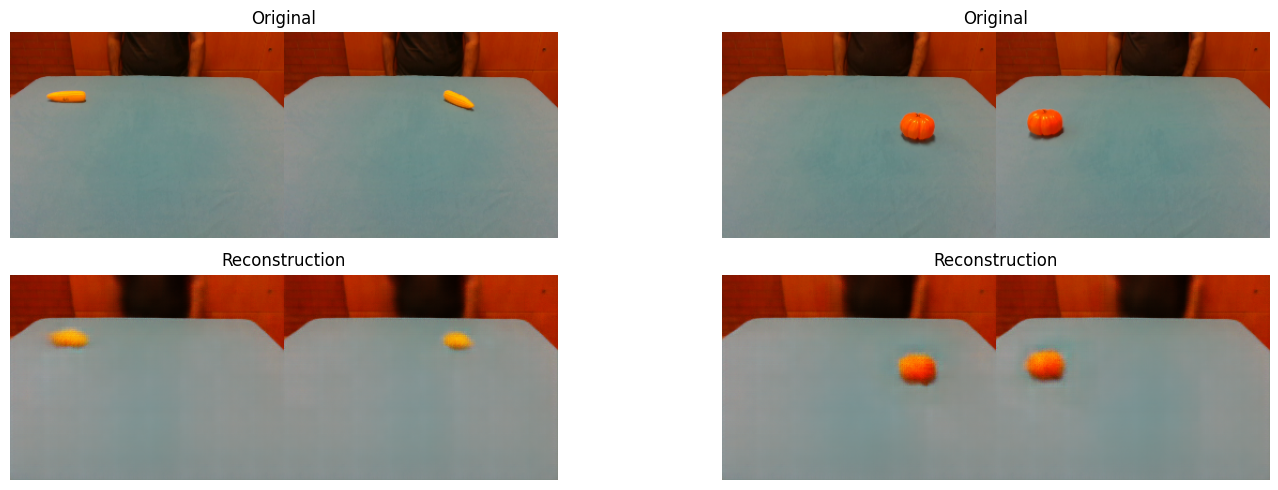

Epoch [4/5], Loss: 0.6101, PSNR: 32.2220, SSIM: 0.9645


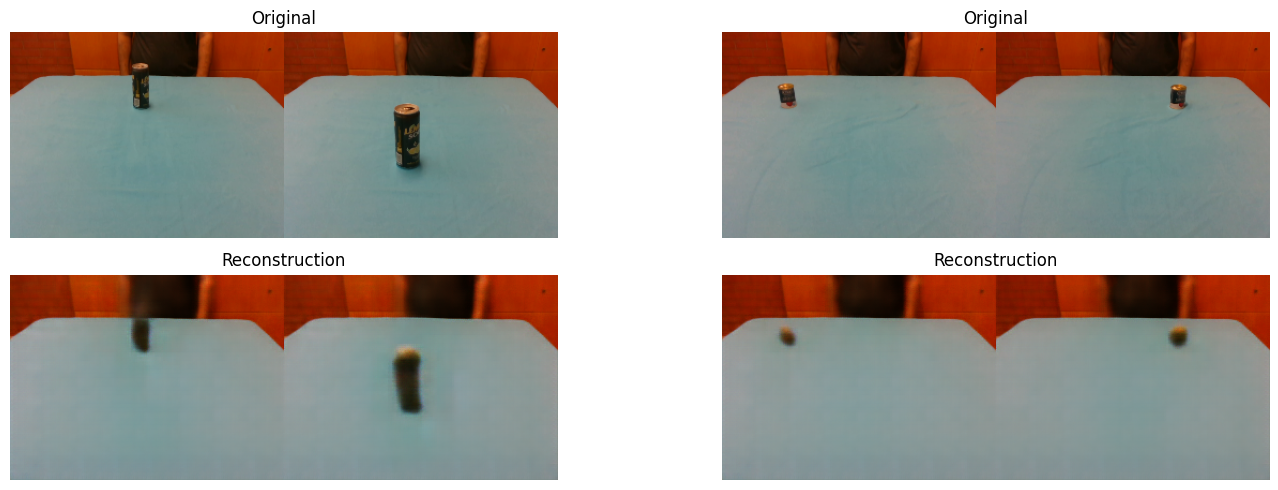

Epoch [5/5], Loss: 0.6099, PSNR: 32.7499, SSIM: 0.9692


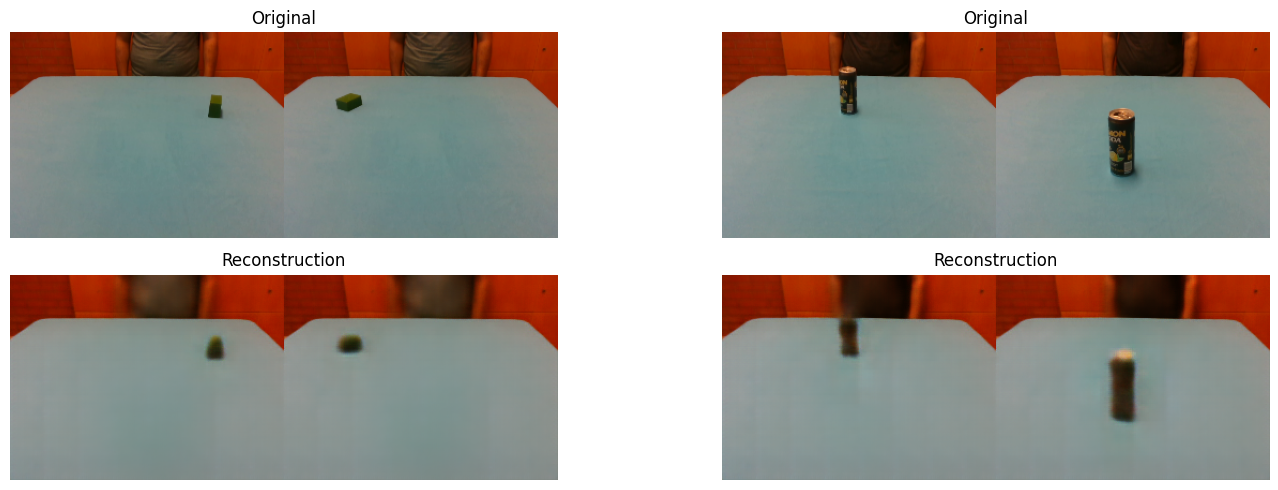

Average Validation Loss: 0.6129777636379004
Average PSNR: 26.934018486606153
Average SSIM: 0.9200647616081099


In [5]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
cae = DeepCAE().to(DEVICE)
cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_epoch_loss_history = train_autoencoder(cae, train_loader, cae_lossfunction, cae_optimizer_adam, NUM_EPOCHS, add_noise=True, device=DEVICE, visualize=True)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, val_loader, cae_lossfunction, DEVICE)

In [6]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/denoise_deepcae_ne5_b4.pth"
torch.save(trained_cae.state_dict(), model_path)

In [6]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne5_b4.pth"
trained_cae = DeepCAE()
trained_cae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 10
LR_RATE = 1e-3
BATCH_SIZE = 4

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, test_loader, label=1, add_noise=True, device=DEVICE)
val_dataset = get_latent_dataset(trained_cae, train_loader, label=1, add_noise=True, device=DEVICE)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = MLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(trained_mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/10], Train Loss: 0.8759, Train Acc: 0.6828, Train Precision: 0.6876, Train Recall: 0.6828, Train F1: 0.6839
Epoch [2/10], Train Loss: 0.2951, Train Acc: 0.9125, Train Precision: 0.9127, Train Recall: 0.9125, Train F1: 0.9125
Epoch [3/10], Train Loss: 0.1935, Train Acc: 0.9313, Train Precision: 0.9314, Train Recall: 0.9313, Train F1: 0.9313
Epoch [4/10], Train Loss: 0.0578, Train Acc: 0.9812, Train Precision: 0.9815, Train Recall: 0.9812, Train F1: 0.9813
Epoch [5/10], Train Loss: 0.1061, Train Acc: 0.9625, Train Precision: 0.9625, Train Recall: 0.9625, Train F1: 0.9625
Epoch [6/10], Train Loss: 0.0183, Train Acc: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Train F1: 0.9953
Epoch [7/10], Train Loss: 0.0044, Train Acc: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch [8/10], Train Loss: 0.0009, Train Acc: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch [9/10], Train Loss: 0.0004, Train Acc: 1.0000, Train Preci

In [ ]:
"early_stopping"
"superimpose"